In [1]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# General definitions
rootdir = ".."
data_directory = os.path.join(rootdir, "hpob")
search_space_id = "4796"
part = "test"

In [3]:
# Approach definitions
num_particles = 100
num_random_trajectories = 50
horizon = 3
optimizer="sgd"
lr = 0.001
mpc_seed = 5

In [4]:
# get part files
with open(os.path.join(data_directory, "splits", f"{part}.json"), "r") as f:
    files = json.load(f)[search_space_id]

In [25]:
# get individual task names
mdf = pd.DataFrame()
mdf_rank = pd.DataFrame()
for task in files:

    approach_results = dict()
    variant_name = "{pre_trained} {apply_lookahead}"
    for pre_trained in [True, False]:
        for apply_lookahead in [True, False]:
            approach_results_path = os.path.join(rootdir, "results", "pre-trained" if pre_trained else "random-initialization",
                                                 search_space_id, f"horizon-{horizon}",
                                                 f"trajectories-{num_random_trajectories}",
                                                 f"particles-{num_particles}",
                                                 "LookAhead" if apply_lookahead else "MPC",
                                                 optimizer, f"lr-{lr}", f"mpc-{mpc_seed}", task)
            temp_results = pd.read_csv(os.path.join(approach_results_path, "expectations.csv"), index_col=0)
            approach_results.update({variant_name.format(pre_trained="pre-trained" if pre_trained else "random",
                                                         apply_lookahead="LookAhead" if apply_lookahead else "MPC"):temp_results})
    for hpo_seed in range(5):
        seed_results = pd.DataFrame()
        for approach in approach_results:
            df = approach_results[approach]
            df = df[df["seed"]==hpo_seed][["expected_regret", "rollout_regret", "regret"]].reset_index(drop=True)
            df_rank = df.rank(axis=1)
            df_rank["seed"] = hpo_seed
            df["seed"] = hpo_seed
            df = df.reset_index(drop=False).rename(columns={"index":"Trial"})
            df["Trial"] += 1
            df["Task"] = task
            df["Method"] = approach
            df_rank["Trial"] = df["Trial"].copy()
            df_rank["Task"] = df["Task"].copy()
            df_rank["Method"] = df["Method"].copy()
            mdf = pd.concat([mdf, df], axis=0).reset_index(drop=True)
            mdf_rank = pd.concat([mdf_rank, df_rank], axis=0).reset_index(drop=True)


In [27]:
error = mdf.copy()
error["expected_regret"] -= error["regret"]
error["rollout_regret"] -= error["regret"]

,Trial,Method,Task,seed,variable,value
0,1,pre-trained LookAhead,3549,0,expected_regret,0.035981
1,2,pre-trained LookAhead,3549,0,expected_regret,0.352834
2,3,pre-trained LookAhead,3549,0,expected_regret,0.138590
3,4,pre-trained LookAhead,3549,0,expected_regret,0.639759
4,5,pre-trained LookAhead,3549,0,expected_regret,0.090000
...,...,...,...,...,...,...
11091,96,random MPC,23,4,rollout_regret,-0.010198
11092,97,random MPC,23,4,rollout_regret,-0.010198
11093,98,random MPC,23,4,rollout_regret,-0.010198
11094,99,random MPC,23,4,rollout_regret,-0.010198


In [29]:
error_melt = pd.melt(error, id_vars=["Trial", "Method", "Task", "seed"], value_vars=["expected_regret", "rollout_regret"]).rename(columns={"variable": "Regret"})


In [30]:
error_melt

,Trial,Method,Task,seed,Regret,value
0,1,pre-trained LookAhead,3549,0,expected_regret,0.035981
1,2,pre-trained LookAhead,3549,0,expected_regret,0.352834
2,3,pre-trained LookAhead,3549,0,expected_regret,0.138590
3,4,pre-trained LookAhead,3549,0,expected_regret,0.639759
4,5,pre-trained LookAhead,3549,0,expected_regret,0.090000
...,...,...,...,...,...,...
11091,96,random MPC,23,4,rollout_regret,-0.010198
11092,97,random MPC,23,4,rollout_regret,-0.010198
11093,98,random MPC,23,4,rollout_regret,-0.010198
11094,99,random MPC,23,4,rollout_regret,-0.010198


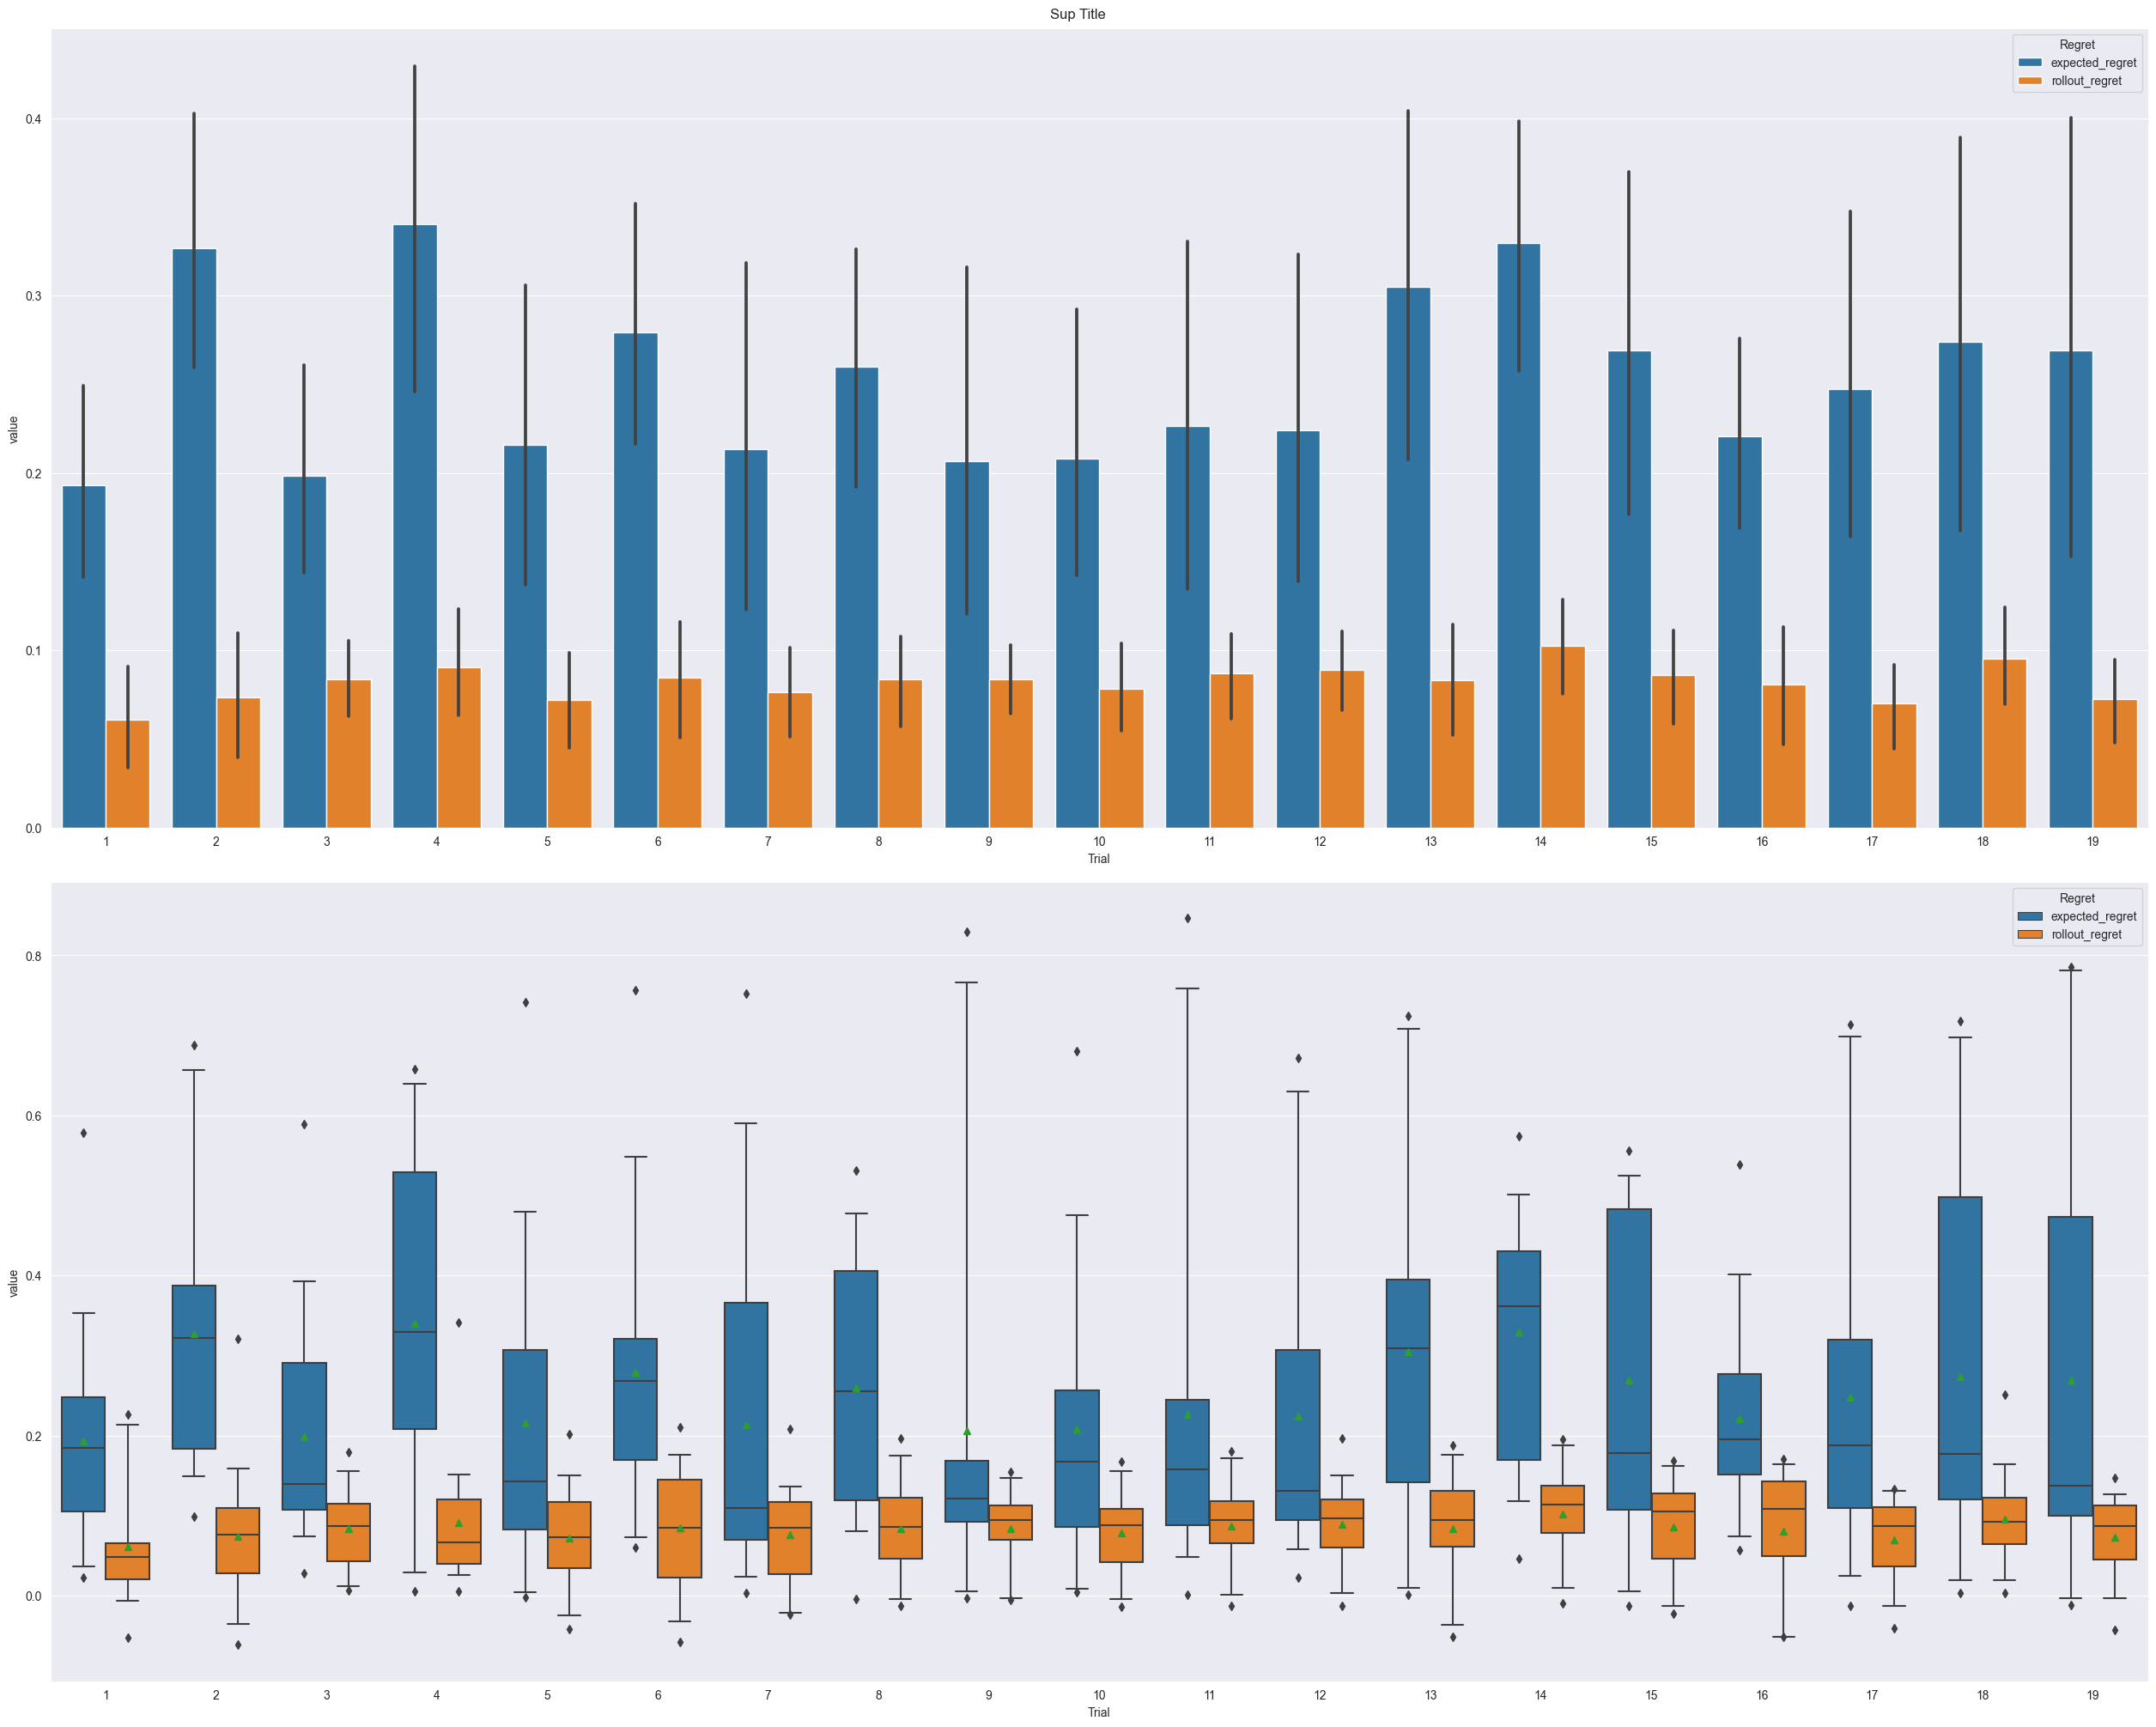

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(25, 20), constrained_layout=True)
fig.suptitle("Sup Title")
g2=sns.barplot(data=error_melt[(error_melt["Method"]=="pre-trained LookAhead") & (error_melt["Trial"]<20)], x="Trial", y='value', hue='Regret', ax=ax[0])
g3=sns.boxplot(data=error_melt[(error_melt["Method"]=="pre-trained LookAhead") & (error_melt["Trial"]<20)], x="Trial", y='value', orient='v', hue='Regret', showmeans=True, whis=[0.5, 99.5], ax=ax[1])

In [ ]:
# correlation between trial and error